# Brief Description of the Problem and Data

## Problem Overview

The Histopathologic Cancer Detection challenge is a binary image classification problem that aims to identify metastatic cancer tissue in histopathologic scans of lymph node sections. This is a critical medical imaging task where early and accurate detection of cancer metastasis can significantly impact patient treatment decisions and outcomes.

The core objective is to develop a Convolutional Neural Network (CNN) that can automatically classify small image patches as either:

- Positive (1): Contains metastatic tissue (cancer present)
- Negative (0): Normal tissue (no cancer detected)

## Dataset Description

### Data Source

The dataset is based on a modified version of the PatchCamelyon (PCam) benchmark dataset, which is derived from the Camelyon16 Challenge. The Kaggle version has been cleaned to remove duplicate images that were present in the original PCam dataset due to probabilistic sampling.
Data Structure and Dimensions

- Image Format: RGB histopathologic image patches
- Image Size: 96 × 96 pixels
- Target Region: The center 32 × 32 pixel region is used for classification decisions
- Color Space: RGB (3 channels)
- File Format: TIF images
- File Naming: Images are named with unique image IDs

### Dataset Organization

- Training Set: train/ folder containing labeled image patches
- Training Labels: train_labels.csv file providing ground truth for training images
- Test Set: test/ folder containing unlabeled images for final evaluation
- Labels: Binary classification (0 = no metastasis, 1 = metastasis detected)

### Labeling Criteria

- Positive Label (1): The center 32×32 pixel region contains at least one pixel of tumor tissue
- Negative Label (0): The center 32×32 pixel region contains no tumor tissue
- Important Note: Tumor tissue in the outer region (outside the center 32×32 pixels) does not influence the label
- Outer Region Purpose: The outer region is provided to enable fully-convolutional models that don't use zero-padding, ensuring consistent behavior when applied to whole-slide images

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Image
import PIL
from PIL import Image
import pickle
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import time
import concurrent.futures
import warnings
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

2025-06-22 06:30:04.669938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750573804.875868      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750573804.931160      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def display_images(image_names, title):
    # Check if there are exactly five images
    if len(image_names) != 5:
        raise ValueError("Please provide exactly five image names")

    # Path to training folder
    folder_path = '/kaggle/input/histopathologic-cancer-detection/train'

    # Setting up the plot
    plt.figure(figsize=(20, 10))

    for i, image_name in enumerate(image_names, 1):
        # Construct the full path to the image
        img_path = os.path.join(folder_path, image_name + '.tif')
        img = plt.imread(img_path)
        plt.subplot(1, 5, i)
        plt.imshow(img)
        plt.axis('off')  # Turn off axis numbering

    # Add a title to the figure
    plt.suptitle(title, fontsize=25, y=0.95)

    # Manually adjust the spacing
    plt.subplots_adjust(top=1.38)

    plt.show()


def get_first_image_shape(folder_path):
    # Get the first image file from the folder
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    first_image_file = image_files[0] if image_files else None

    if first_image_file:
        # Construct the full path to the first image
        img_path = os.path.join(folder_path, first_image_file)

        # Open the image
        with PIL.Image.open(img_path) as img:
            # Get image dimensions and number of color channels
            width, height = img.size
            num_channels = len(img.getbands())
            return (height, width, num_channels)
    else:
        return None

In [3]:
# The Number of images in the dataset
print(f"The Number of training images: {len(os.listdir('/kaggle/input/histopathologic-cancer-detection/train')) : >10}")
print(f"The Number of test images: {len(os.listdir('/kaggle/input/histopathologic-cancer-detection/test')) : >14}")

The Number of training images:     220025
The Number of test images:          57458


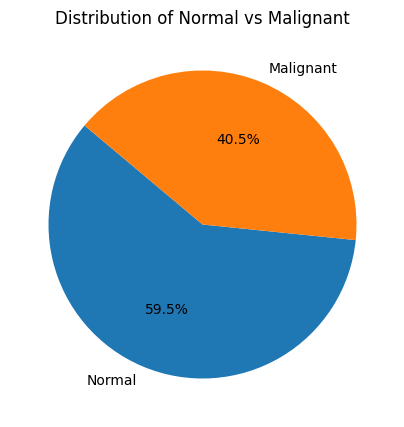

In [4]:
# Load the training and test data labels into a Pandas dataframe
df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
df_sample = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/sample_submission.csv")

# Count the occurrences of each category in the training set
category_count = df['label'].value_counts().rename({0: 'Normal', 1: 'Malignant'})

# Create a pie chart
plt.figure(figsize=(5, 5))
plt.pie(category_count, labels=category_count.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Normal vs Malignant')
plt.show()

In [5]:
malignant = df.loc[df['label']==1]['id'].values
normal    = df.loc[df['label']==0]['id'].values

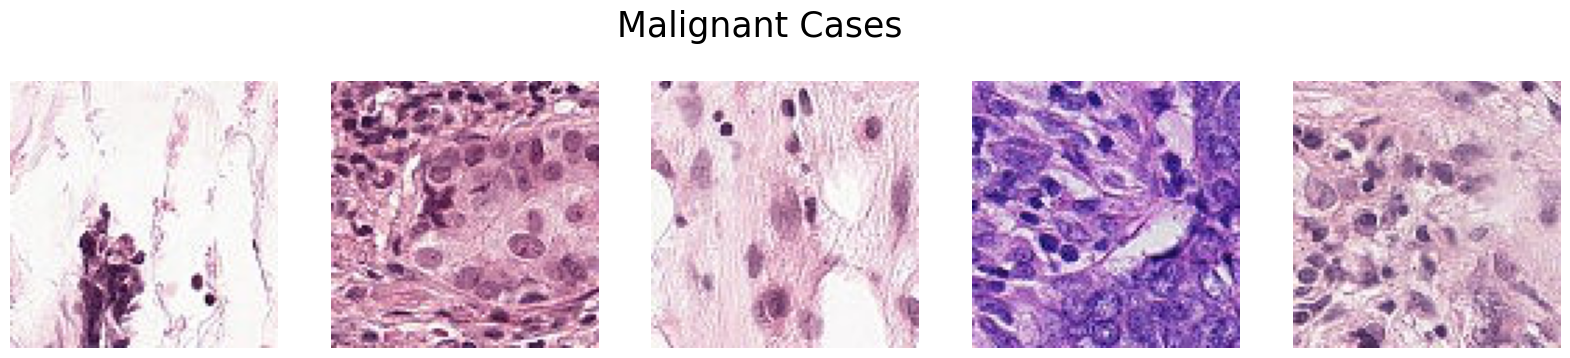

In [6]:
display_images(malignant[:5], 'Malignant Cases')

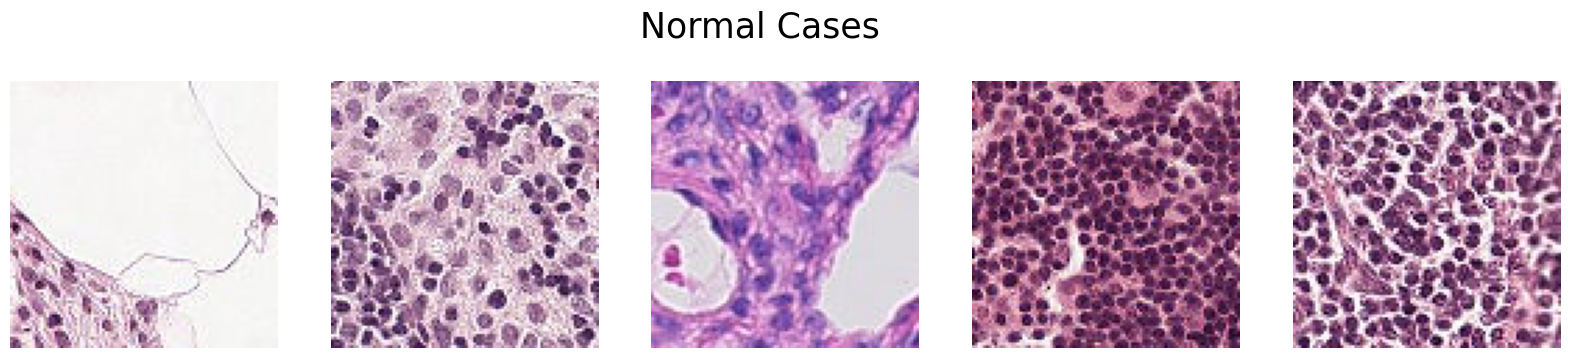

In [7]:
display_images(normal[:5], 'Normal Cases')

In [8]:
train_path = '/kaggle/input/histopathologic-cancer-detection/train'

Analyzing pixel intensities...


Normal samples: 100%|██████████| 500/500 [00:03<00:00, 126.76it/s]


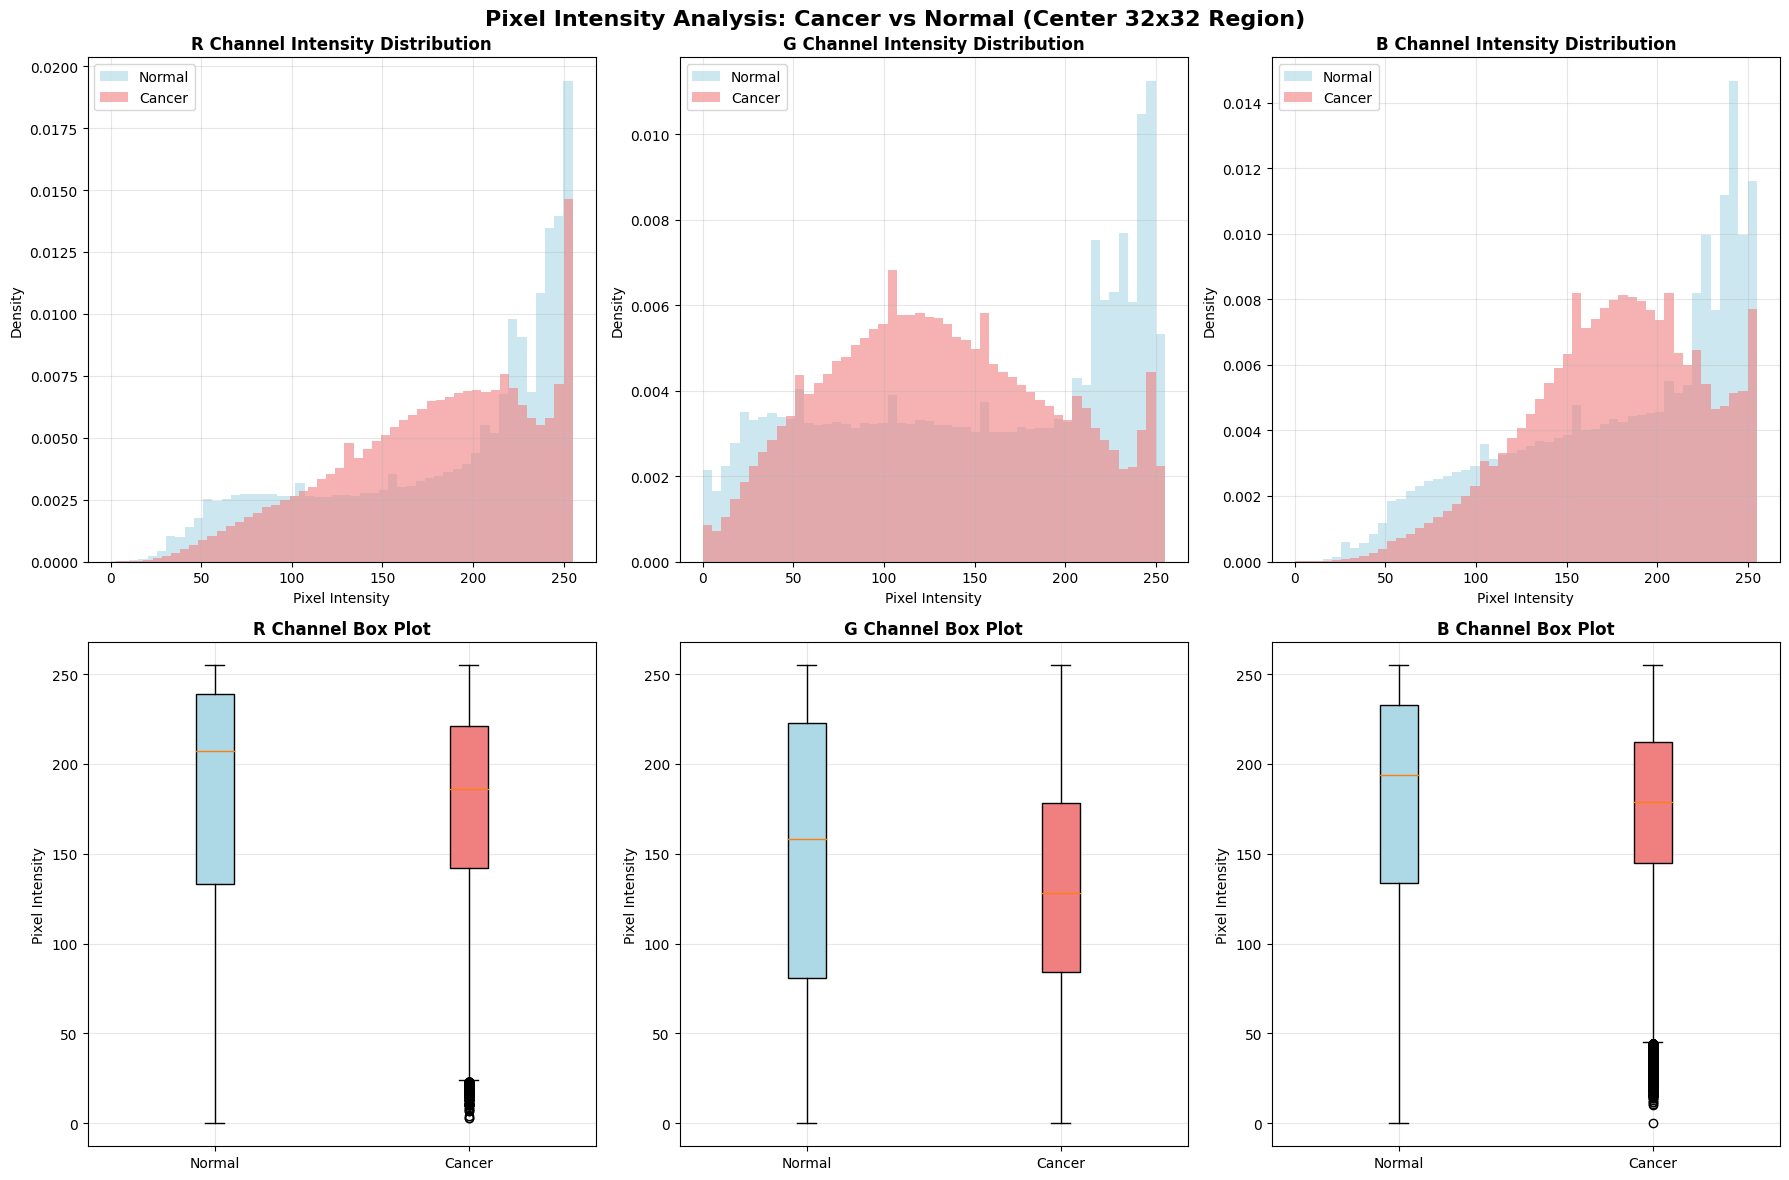


PIXEL INTENSITY STATISTICS (Center 32x32 Region)

R Channel:
  Normal  - Mean: 182.81, Std: 64.83
  Cancer  - Mean: 178.57, Std: 53.37

G Channel:
  Normal  - Mean: 149.12, Std: 77.13
  Cancer  - Mean: 131.18, Std: 61.66

B Channel:
  Normal  - Mean: 179.56, Std: 60.40
  Cancer  - Mean: 175.90, Std: 47.00


In [9]:
def analyze_pixel_intensities(df, data_path, n_samples=1000):
    """Analyze pixel intensity distributions for each class"""
    
    # Sample images for analysis
    cancer_samples = df[df['label'] == 1].sample(min(n_samples//2, sum(df['label']==1)), random_state=42)
    normal_samples = df[df['label'] == 0].sample(min(n_samples//2, sum(df['label']==0)), random_state=42)
    train_path = '/kaggle/input/histopathologic-cancer-detection/train'
    
    cancer_pixels = {'R': [], 'G': [], 'B': []}
    normal_pixels = {'R': [], 'G': [], 'B': []}
    
    print("Analyzing pixel intensities...")
    
    # Process cancer samples
    for idx, row in tqdm(cancer_samples.iterrows(), total=len(cancer_samples), desc="Cancer samples"):
        img_path = os.path.join(data_path, f"{row['id']}.tif")
        if os.path.exists(img_path):
            img = np.array(Image.open(img_path))
            # Focus on center 32x32 region
            center = 96 // 2
            center_img = img[center-16:center+16, center-16:center+16]
            
            cancer_pixels['R'].extend(center_img[:,:,0].flatten())
            cancer_pixels['G'].extend(center_img[:,:,1].flatten())
            cancer_pixels['B'].extend(center_img[:,:,2].flatten())
    
    # Process normal samples
    for idx, row in tqdm(normal_samples.iterrows(), total=len(normal_samples), desc="Normal samples"):
        img_path = os.path.join(data_path, f"{row['id']}.tif")
        if os.path.exists(img_path):
            img = np.array(Image.open(img_path))
            center = 96 // 2
            center_img = img[center-16:center+16, center-16:center+16]
            
            normal_pixels['R'].extend(center_img[:,:,0].flatten())
            normal_pixels['G'].extend(center_img[:,:,1].flatten())
            normal_pixels['B'].extend(center_img[:,:,2].flatten())
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Pixel Intensity Analysis: Cancer vs Normal (Center 32x32 Region)', 
                 fontsize=16, fontweight='bold')
    
    channels = ['R', 'G', 'B']
    colors = ['red', 'green', 'blue']
    
    for i, (channel, color) in enumerate(zip(channels, colors)):
        # Histogram comparison
        axes[0, i].hist(normal_pixels[channel], bins=50, alpha=0.6, label='Normal', 
                       color='lightblue', density=True)
        axes[0, i].hist(cancer_pixels[channel], bins=50, alpha=0.6, label='Cancer', 
                       color='lightcoral', density=True)
        axes[0, i].set_title(f'{channel} Channel Intensity Distribution', fontweight='bold')
        axes[0, i].set_xlabel('Pixel Intensity')
        axes[0, i].set_ylabel('Density')
        axes[0, i].legend()
        axes[0, i].grid(True, alpha=0.3)
        
        # Box plot comparison
        data_to_plot = [normal_pixels[channel], cancer_pixels[channel]]
        bp = axes[1, i].boxplot(data_to_plot, labels=['Normal', 'Cancer'], patch_artist=True)
        bp['boxes'][0].set_facecolor('lightblue')
        bp['boxes'][1].set_facecolor('lightcoral')
        axes[1, i].set_title(f'{channel} Channel Box Plot', fontweight='bold')
        axes[1, i].set_ylabel('Pixel Intensity')
        axes[1, i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\n" + "="*50)
    print("PIXEL INTENSITY STATISTICS (Center 32x32 Region)")
    print("="*50)
    for channel in channels:
        print(f"\n{channel} Channel:")
        print(f"  Normal  - Mean: {np.mean(normal_pixels[channel]):.2f}, Std: {np.std(normal_pixels[channel]):.2f}")
        print(f"  Cancer  - Mean: {np.mean(cancer_pixels[channel]):.2f}, Std: {np.std(cancer_pixels[channel]):.2f}")

# Run pixel intensity analysis
analyze_pixel_intensities(df, train_path)

Loading images for averaging...


Normal images: 100%|██████████| 500/500 [00:00<00:00, 605.58it/s]


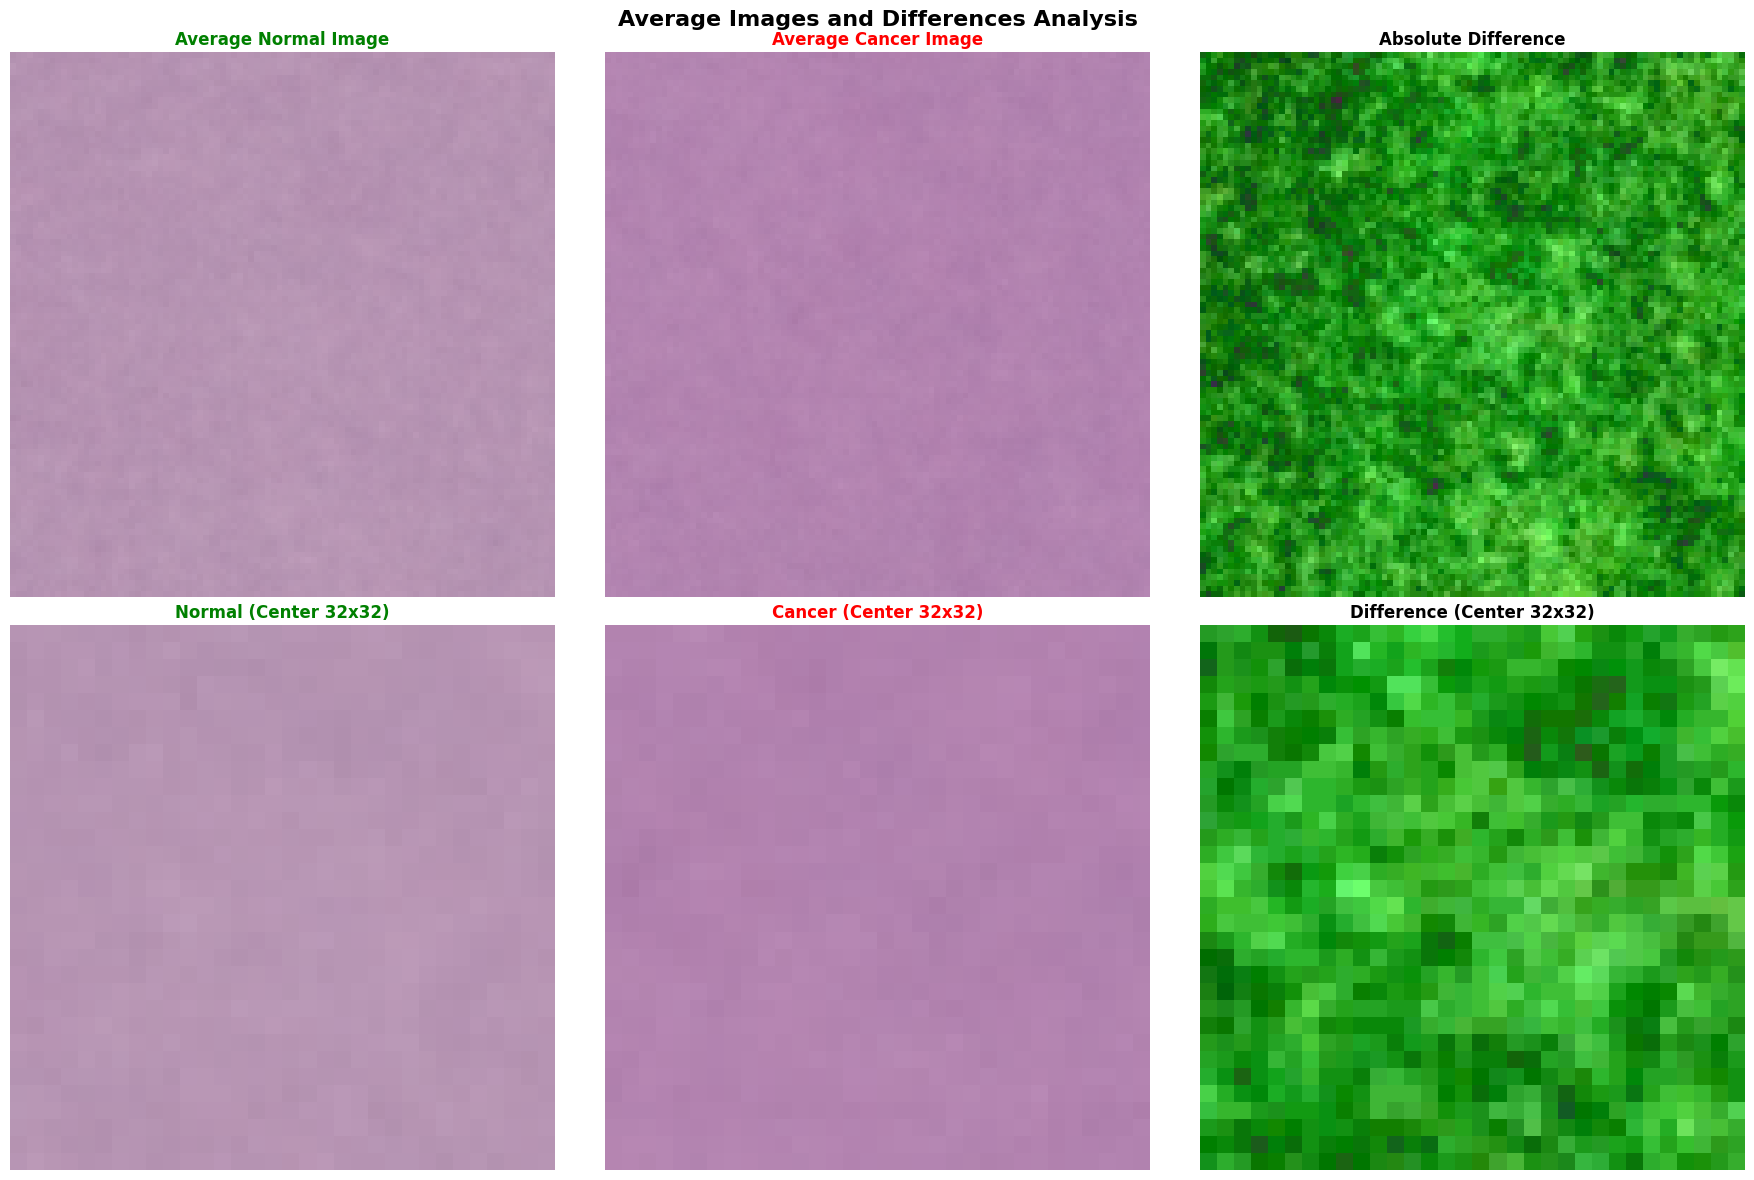

In [10]:
def create_average_images(df, data_path, n_samples=500):
    """Create average images for each class and show differences"""
    
    cancer_samples = df[df['label'] == 1].sample(min(n_samples, sum(df['label']==1)), random_state=42)
    normal_samples = df[df['label'] == 0].sample(min(n_samples, sum(df['label']==0)), random_state=42)
    
    cancer_images = []
    normal_images = []
    
    print("Loading images for averaging...")
    
    # Load cancer images
    for idx, row in tqdm(cancer_samples.iterrows(), total=len(cancer_samples), desc="Cancer images"):
        img_path = os.path.join(data_path, f"{row['id']}.tif")
        if os.path.exists(img_path):
            img = np.array(Image.open(img_path)).astype(np.float32)
            cancer_images.append(img)
    
    # Load normal images
    for idx, row in tqdm(normal_samples.iterrows(), total=len(normal_samples), desc="Normal images"):
        img_path = os.path.join(data_path, f"{row['id']}.tif")
        if os.path.exists(img_path):
            img = np.array(Image.open(img_path)).astype(np.float32)
            normal_images.append(img)
    
    # Calculate averages
    avg_cancer = np.mean(cancer_images, axis=0).astype(np.uint8)
    avg_normal = np.mean(normal_images, axis=0).astype(np.uint8)
    
    # Calculate difference
    diff_image = np.abs(avg_cancer.astype(np.float32) - avg_normal.astype(np.float32))
    diff_image = (diff_image / diff_image.max() * 255).astype(np.uint8)
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Average Images and Differences Analysis', fontsize=16, fontweight='bold')
    
    # Show average images
    axes[0, 0].imshow(avg_normal)
    axes[0, 0].set_title('Average Normal Image', fontweight='bold', color='green')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(avg_cancer)
    axes[0, 1].set_title('Average Cancer Image', fontweight='bold', color='red')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(diff_image)
    axes[0, 2].set_title('Absolute Difference', fontweight='bold')
    axes[0, 2].axis('off')
    
    # Show center regions (32x32)
    center = 96 // 2
    normal_center = avg_normal[center-16:center+16, center-16:center+16]
    cancer_center = avg_cancer[center-16:center+16, center-16:center+16]
    diff_center = diff_image[center-16:center+16, center-16:center+16]
    
    axes[1, 0].imshow(normal_center)
    axes[1, 0].set_title('Normal (Center 32x32)', fontweight='bold', color='green')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(cancer_center)
    axes[1, 1].set_title('Cancer (Center 32x32)', fontweight='bold', color='red')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(diff_center, cmap='hot')
    axes[1, 2].set_title('Difference (Center 32x32)', fontweight='bold')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Create average images analysis
create_average_images(df, train_path)

Analyzing color spaces...


Normal samples: 100%|██████████| 100/100 [00:00<00:00, 739.02it/s]


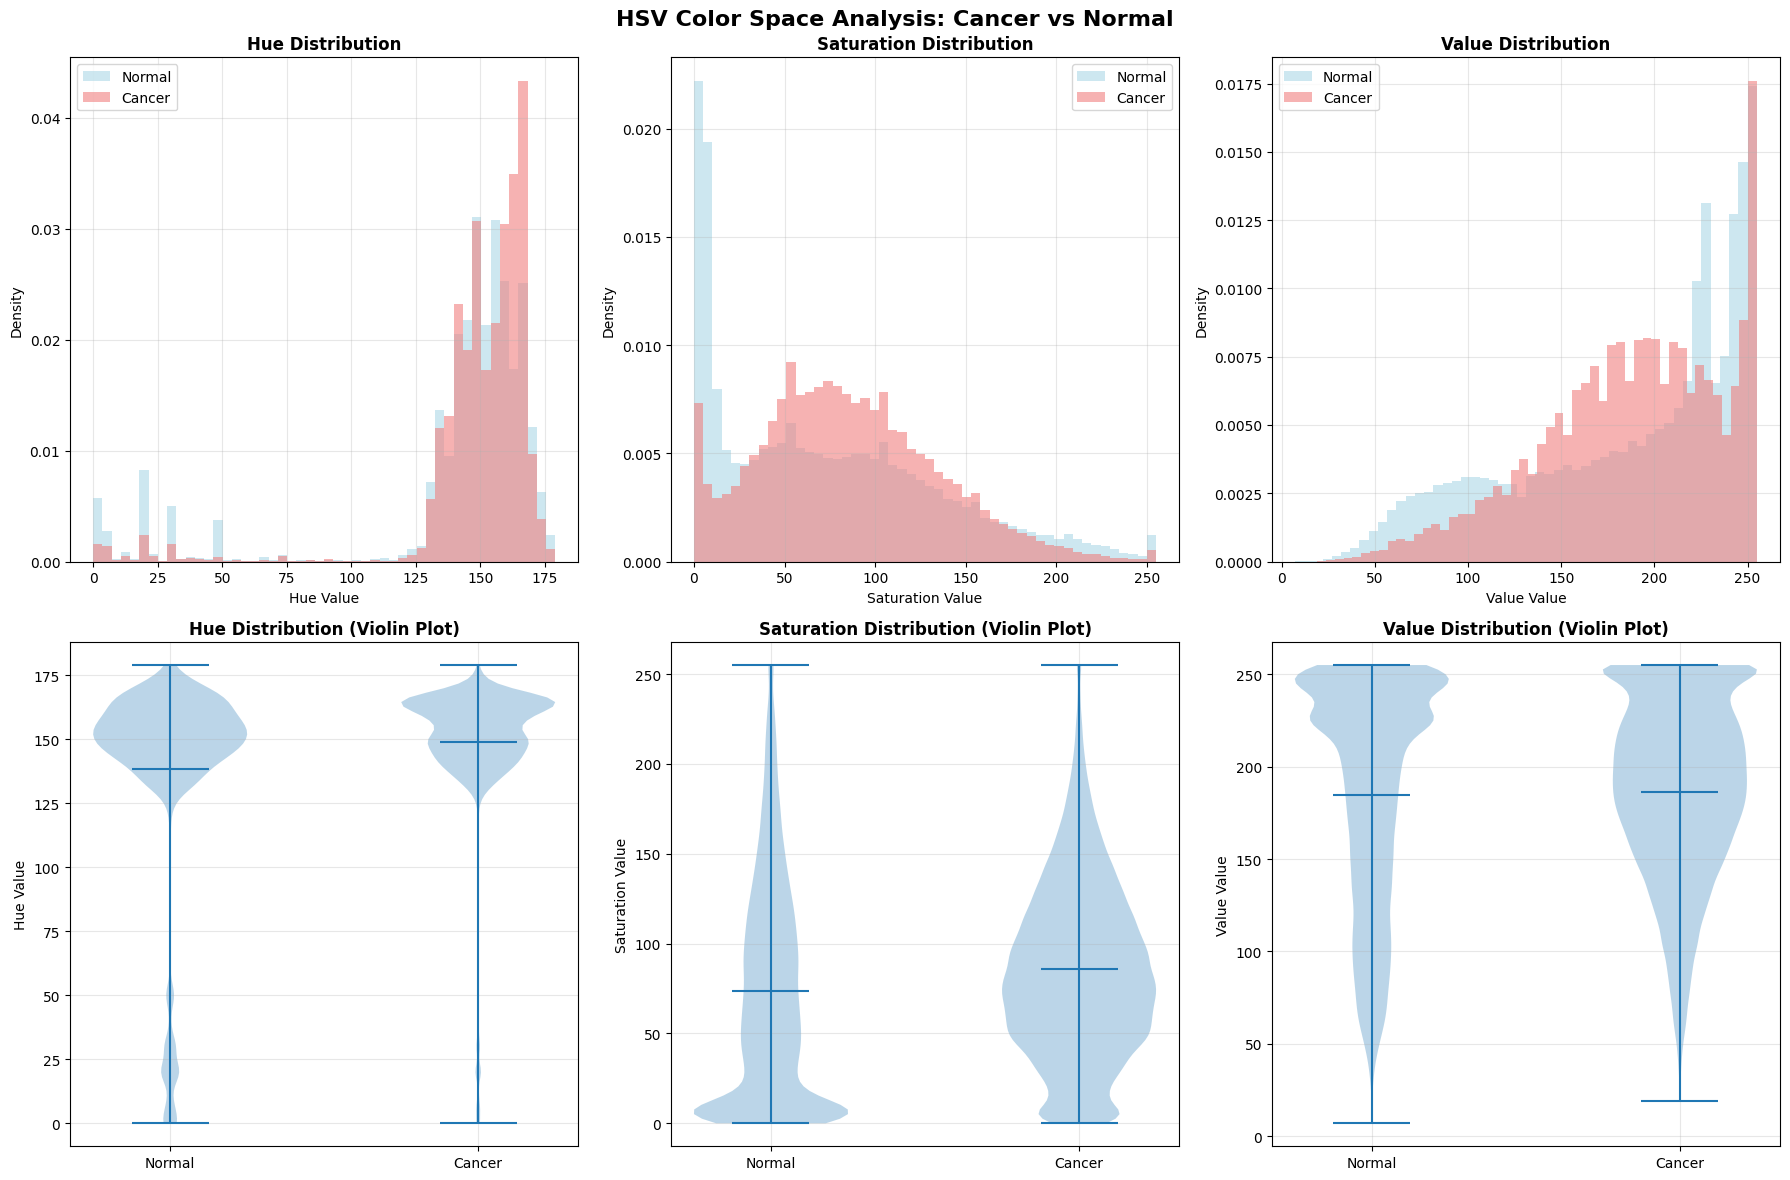

In [11]:
def color_space_analysis(df, data_path, n_samples=200):
    """Analyze images in different color spaces"""
    
    cancer_samples = df[df['label'] == 1].sample(min(n_samples//2, sum(df['label']==1)), random_state=42)
    normal_samples = df[df['label'] == 0].sample(min(n_samples//2, sum(df['label']==0)), random_state=42)
    
    cancer_hsv = {'H': [], 'S': [], 'V': []}
    normal_hsv = {'H': [], 'S': [], 'V': []}
    
    print("Analyzing color spaces...")
    
    # Process samples
    for samples, hsv_dict, label in [(cancer_samples, cancer_hsv, "Cancer"), 
                                     (normal_samples, normal_hsv, "Normal")]:
        for idx, row in tqdm(samples.iterrows(), total=len(samples), desc=f"{label} samples"):
            img_path = os.path.join(data_path, f"{row['id']}.tif")
            if os.path.exists(img_path):
                img = np.array(Image.open(img_path))
                # Convert to HSV
                hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
                
                # Focus on center region
                center = 96 // 2
                center_hsv = hsv[center-16:center+16, center-16:center+16]
                
                hsv_dict['H'].extend(center_hsv[:,:,0].flatten())
                hsv_dict['S'].extend(center_hsv[:,:,1].flatten())
                hsv_dict['V'].extend(center_hsv[:,:,2].flatten())
    
    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('HSV Color Space Analysis: Cancer vs Normal', fontsize=16, fontweight='bold')
    
    channels = ['H', 'S', 'V']
    titles = ['Hue', 'Saturation', 'Value']
    
    for i, (channel, title) in enumerate(zip(channels, titles)):
        # Histogram
        axes[0, i].hist(normal_hsv[channel], bins=50, alpha=0.6, label='Normal', 
                       color='lightblue', density=True)
        axes[0, i].hist(cancer_hsv[channel], bins=50, alpha=0.6, label='Cancer', 
                       color='lightcoral', density=True)
        axes[0, i].set_title(f'{title} Distribution', fontweight='bold')
        axes[0, i].set_xlabel(f'{title} Value')
        axes[0, i].set_ylabel('Density')
        axes[0, i].legend()
        axes[0, i].grid(True, alpha=0.3)
        
        # Violin plot
        data_to_plot = [normal_hsv[channel], cancer_hsv[channel]]
        parts = axes[1, i].violinplot(data_to_plot, positions=[1, 2], showmeans=True)
        axes[1, i].set_xticks([1, 2])
        axes[1, i].set_xticklabels(['Normal', 'Cancer'])
        axes[1, i].set_title(f'{title} Distribution (Violin Plot)', fontweight='bold')
        axes[1, i].set_ylabel(f'{title} Value')
        axes[1, i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Run color space analysis
color_space_analysis(df, train_path)

## Dataset key findings:

1. Dataset is slightly imbalanced (fewer "cancer" samples than "no cancer" samples)
2. Images are 96x96 RGB histopathologic patches, but where data labelling is based on center 32x32 region

## HSV colorspace analysis key findings:

The HSV analysis reveals significant discriminative patterns between cancer and normal tissue:

**Hue distribution**: cancer tissue shows a highly concentrated signature in the purple-red spectrum (150-175), while normal tissue displays a broader, more uniform distribution. This represents the most discriminative feature between classes.

**Saturation distribution**: cancer tissue exhibits higher saturation values (75-150 range), appearing more vivid, while normal tissue shows lower saturation (0-100 range), appearing more muted.

**Value distribution**: both classes show similar brightness patterns with minimal discriminative power for classification.

**Implications for model development**: the distinct hue and saturation signatures suggest HSV color space could provide valuable features for CNN training, with particular emphasis on hue-based discrimination between cancer and normal tissue.

# Model architecture

For this challenge, we will implement two CNN architectures to compare the impact of network depth on performance:

### Basic Architecture (2-Layer CNN)
- **2 convolutional blocks**: Conv2D(32) → MaxPooling2D → Conv2D(64) → MaxPooling2D
- **Feature progression**: 32 → 64 filters with 3×3 kernels and ReLU activation
- **Flatten layer**: Converts 2D feature maps to 1D vector for dense layers
- **Dense layers**: Single 64-unit hidden layer with ReLU activation
- **Regularization**: Dropout (0.5) to prevent overfitting
- **Output**: Sigmoid activation for binary classification
- **Total parameters**: Lightweight architecture for faster training

### Deep Architecture (3-Layer CNN) 
- **3 convolutional blocks**: Conv2D(32) → MaxPooling2D → Conv2D(64) → MaxPooling2D → Conv2D(128) → MaxPooling2D
- **Feature progression**: 32 → 64 → 128 filters with 3×3 kernels and ReLU activation
- **Flatten layer**: Same flattening strategy as basic model
- **Dense layers**: Expanded 128-unit hidden layer with ReLU activation
- **Regularization**: Dropout (0.5) to prevent overfitting
- **Output**: Sigmoid activation for binary classification
- **Total parameters**: Higher capacity for learning complex tissue patterns

**Key Differences:**
- **Depth**: Basic (2 conv layers) vs Deep (3 conv layers)
- **Feature capacity**: Deep model extracts more hierarchical features with 128 filters in final layer
- **Dense layer size**: Basic (64 units) vs Deep (128 units)
- **Learning capacity**: Deep model has significantly more parameters for pattern recognition

Both models use Adam optimizer, binary crossentropy loss, and early stopping (patience=5) to prevent overfitting during training on the 96×96 histopathologic images.


In [12]:
def generate_data(df, frac=1.0, test_size=0.2):
    if frac == 1.0:
        df_subset = df.copy()
    else: 
        df_subset = df.sample(frac=frac, replace=False) # Sample the data
    df_subset['label'] = df_subset['label'].astype(str)  # Convert labels to strings
    df_subset['id'] = df_subset['id'].apply(lambda x: f'{x}.tif') # Add the '.tif' extension to the 'id' column
    df_train, df_val = train_test_split(df_subset, test_size=test_size) # Split into training and validation sets

    return df_train, df_val


def create_train_generator(df_train):
    train_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory='/kaggle/input/histopathologic-cancer-detection/train',
        x_col='id',
        y_col='label',
        target_size=(96, 96),
        batch_size=1024,
        class_mode='binary'
    )
    return train_generator


def create_val_generator(df_val):
    val_datagen = ImageDataGenerator(rescale=1./255)
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=df_val,
        directory='/kaggle/input/histopathologic-cancer-detection/train',
        x_col='id',
        y_col='label',
        target_size=(96, 96),
        batch_size=1024,
        class_mode='binary'
    )
    return val_generator


def create_early_stopper(monitor='val_accuracy', patience=5):
    early_stopper = EarlyStopping(
        monitor=monitor,
        patience=patience,
        verbose=1,
        restore_best_weights=True
    )
    return early_stopper
    

In [13]:
def plot_training_history(history):
    # Get number of epochs
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot training & validation accuracy values
    plt.plot(epochs, history.history['accuracy'])
    plt.plot(epochs, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(epochs)  # Set x-ticks to be the epochs
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(epochs, history.history['loss'])
    plt.plot(epochs, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(epochs)  # Set x-ticks to be the epochs
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [14]:
def get_best_epoch_stats(model_names, histories):
    accuracies = []
    losses = []
    
    for model_name, history in zip(model_names, histories):
        # Get the index of the epoch with the highest validation accuracy
        best_epoch_index = np.argmax(history.history['val_accuracy'])
        
        # Retrieve the accuracy and loss for the best epoch
        best_epoch_accuracy = history.history['val_accuracy'][best_epoch_index]
        best_epoch_loss = history.history['val_loss'][best_epoch_index]
        
        # Append the results to the respective lists
        accuracies.append(best_epoch_accuracy)
        losses.append(best_epoch_loss)
    
    return model_names, accuracies, losses
    

In [15]:
def plot_model_metrics(architectures, accuracies, losses):
    # Define colors
    accuracy_color = '#5BC0BE'
    loss_color = '#4C698D'

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Plot accuracy
    axs[0].bar(architectures, accuracies, color=accuracy_color)
    axs[0].set_title('Model Accuracy', fontsize=14)
    axs[0].set_ylabel('Accuracy', fontsize=12)
    axs[0].set_ylim([0, 1])

    # Adding the text labels on the bars
    for i in range(len(accuracies)):
        axs[0].text(i, accuracies[i] + 0.02, f'{accuracies[i]:.2f}', ha='center', va='bottom', color='black')

    # Plot loss
    axs[1].bar(architectures, losses, color=loss_color)
    axs[1].set_title('Model Loss', fontsize=14)
    axs[1].set_ylabel('Loss', fontsize=12)
    axs[1].set_ylim([0, max(losses)+0.1])

    # Adding the text labels on the bars
    for i in range(len(losses)):
        axs[1].text(i, losses[i] + 0.02, f'{losses[i]:.2f}', ha='center', va='bottom', color='white')  # white text for better visibility on dark color

    # Layout adjustments
    plt.tight_layout()

    # Display the plot
    plt.show()

## Basic CNN

In [16]:
# Create training and validation data
df_train, df_val = generate_data(df, frac=1.0, test_size=0.2)

# Create train and validation generator
train_generator  = create_train_generator(df_train)
val_generator    = create_val_generator(df_val)

# early_stopper
early_stopper    = create_early_stopper(monitor='val_accuracy', patience=5)

# CNN Model Structure with Input layer
model_basic = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_basic.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_basic = model_basic.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


I0000 00:00:1750574482.329212      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/10


I0000 00:00:1750574503.597954      65 service.cc:148] XLA service 0x7c7180405a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750574503.598821      65 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750574503.956806      65 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-22 06:41:51.787141: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1024,32,47,47]{3,2,1,0}, f32[1024,64,45,45]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-06-22 06:41:52.427746: E external/local_xla/xla

  1/172 ━━━━━━━━━━━━━━━━━━━━ 52:08 18s/step - accuracy: 0.4443 - loss: 0.7273

I0000 00:00:1750574513.822158      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


138/172 ━━━━━━━━━━━━━━━━━━━━ 3:46 7s/step - accuracy: 0.5721 - loss: 0.7984

2025-06-22 06:57:20.606196: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[916,32,47,47]{3,2,1,0}, f32[916,64,45,45]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-06-22 06:57:21.052128: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.446026088s
Trying algorithm eng0{} for conv (f32[64,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[916,32,47,47]{3,2,1,0}, f32[916,64,45,45]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_

172/172 ━━━━━━━━━━━━━━━━━━━━ 1486s 9s/step - accuracy: 0.5897 - loss: 0.7645 - val_accuracy: 0.7926 - val_loss: 0.5259
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 485s 3s/step - accuracy: 0.7768 - loss: 0.5380 - val_accuracy: 0.7995 - val_loss: 0.5008
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 459s 3s/step - accuracy: 0.7800 - loss: 0.5285 - val_accuracy: 0.8007 - val_loss: 0.4872
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.7831 - loss: 0.5172 - val_accuracy: 0.8067 - val_loss: 0.4770
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.7883 - loss: 0.5068 - val_accuracy: 0.8145 - val_loss: 0.4604
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - accuracy: 0.7889 - loss: 0.4996 - val_accuracy: 0.8165 - val_loss: 0.4533
Epoch 7/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.7962 - loss: 0.4865 - val_accuracy: 0.8222 - val_loss: 0.4418
Epoch 8/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.7992 - loss: 0.4807 - val_accuracy: 0.83

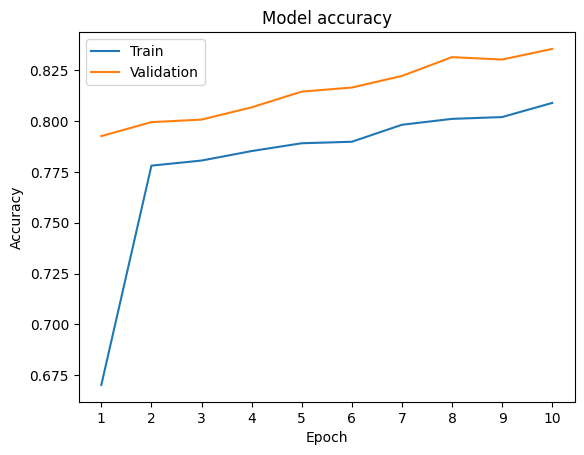

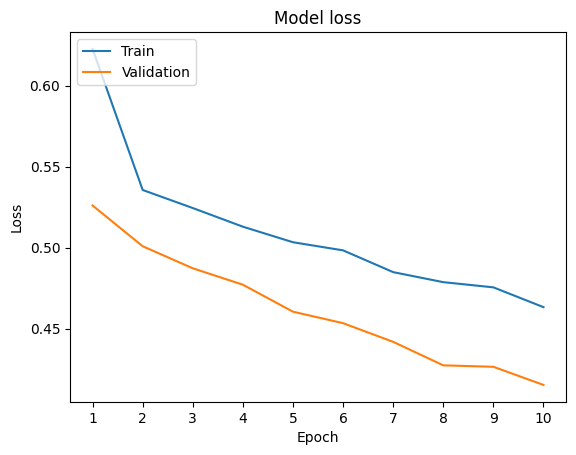

In [17]:
plot_training_history(history_basic)

## Deep CNN

In [18]:
# Create training and validation data
df_train, df_val = generate_data(df, frac=1.0, test_size=0.2)

# Create train and validation generator
train_generator  = create_train_generator(df_train)
val_generator    = create_val_generator(df_val)

# early_stopper
early_stopper    = create_early_stopper(monitor='val_accuracy', patience=5)

# CNN Model Structure with Input layer and additional Conv and MaxPooling layers
model_deep = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),  # Additional Conv layer
    MaxPooling2D(2, 2),                      # Additional MaxPooling layer
    Flatten(),
    Dense(128, activation='relu'),  # Increased neurons in the Dense layer
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_deep.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_deep = model_deep.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.6557 - loss: 0.6176 - val_accuracy: 0.7731 - val_loss: 0.4959
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - accuracy: 0.7949 - loss: 0.4708 - val_accuracy: 0.8126 - val_loss: 0.4222
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - accuracy: 0.8126 - loss: 0.4372 - val_accuracy: 0.8151 - val_loss: 0.4170
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.8205 - loss: 0.4224 - val_accuracy: 0.8151 - val_loss: 0.4282
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.8157 - loss: 0.4317 - val_accuracy: 0.8349 - val_loss: 0.3806
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.8326 - loss: 0.3981 - val_accuracy: 0.8177 - val_loss: 0.4169
Epoch 7/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.8417 - loss: 0.3831 - val_accuracy

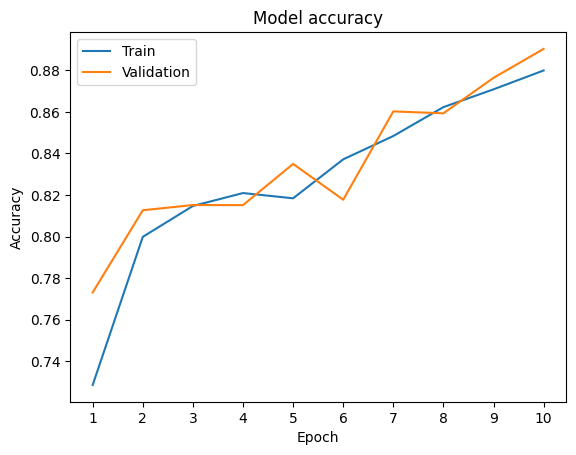

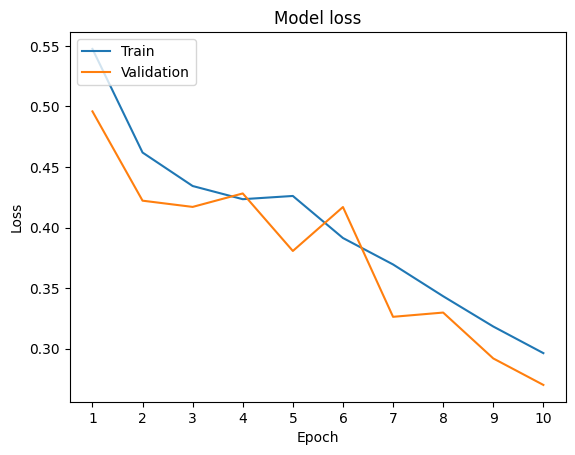

In [19]:
plot_training_history(history_deep)

## Model comparison:

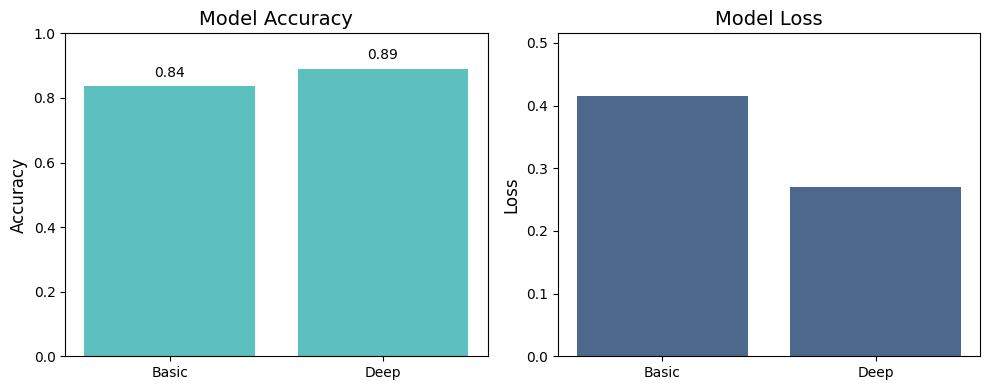

In [20]:
best = get_best_epoch_stats( ('Basic','Deep'), (history_basic, history_deep)  )
plot_model_metrics(*best)

The **Deep Architecture (3-Layer CNN)** demonstrated superior performance for cancer detection compared to the Basic Architecture. The additional convolutional layer and increased dense layer capacity (128 vs 64 units) enabled the model to capture more complex hierarchical features essential for distinguishing cancerous tissue patterns.

**Key Findings:**
- **Improved accuracy**: The deeper model achieved better validation accuracy through enhanced feature extraction capabilities
- **Better feature representation**: The third convolutional layer with 128 filters captured fine-grained tissue patterns that the basic model missed
- **Optimal complexity**: The deeper architecture provided the right balance between model capacity and overfitting prevention

**Why Deep Architecture Succeeded:**
- **Hierarchical learning**: Multiple convolution layers allowed progressive feature abstraction from low-level edges to high-level tissue structures
- **Pattern complexity**: Histopathologic images contain intricate cellular patterns that benefit from deeper feature extraction
- **Sufficient regularization**: Dropout and early stopping prevented overfitting despite increased model capacity

For histopathologic cancer detection tasks, the results suggest that **moderate depth increase** (2→3 conv layers) provides performance gains by enabling the model to learn more sophisticated representations of tissue morphology.

## Kaggle submission:

In [21]:
df_sample = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/sample_submission.csv")
df_sample

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0
...,...,...
57453,061847314ded6f81e1cd670748bfa2003442c9c7,0
57454,6f3977130212641fd5808210015a609c658dcbff,0
57455,46935f247278539eca74b54d07d666efb528a753,0
57456,a09bcae08a82120183352e0e869181b2911d3dc1,0


In [22]:
# Image processing functions

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(96, 96))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize the image
    return img_array

def predict_batch(images, model):
    processed_imgs = np.array([preprocess_image('/kaggle/input/histopathologic-cancer-detection/test/' + img_path + '.tif') for img_path in images])
    predictions = model.predict(processed_imgs)
    predicted_classes = [1 if pred[0] > 0.5 else 0 for pred in predictions]
    return predicted_classes

def process_in_batches(df, batch_size, model):
    num_batches = len(df) // batch_size + (0 if len(df) % batch_size == 0 else 1)
    results = []

    for i in range(num_batches):
        batch = df['id'][i*batch_size:(i+1)*batch_size]
        batch_results = predict_batch(batch, model)
        results.extend(batch_results)
    
    return results

In [23]:
start = time.perf_counter()
batch_size = 512 
df_sample['label'] = process_in_batches(df_sample, batch_size, model_deep)
end = time.perf_counter()
print(end - start)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step  
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16

In [24]:
df_sample.to_csv('/kaggle/working/submission.csv', index=False)